In [1]:
import numpy as np
import proplot as pplt

import sys
import os
os.environ["RDMAV_FORK_SAFE"] = "1"
sys.path.append("/home/sem/github/XXModelNQS/project/")

In [2]:
N = 10

In [3]:
from src.struct import Results
import netket as nk

In [4]:
hh = np.linspace(0.5, 1.5, 100)

In [5]:
sx = 0.5 * np.array([[0, 1], [1, 0]], dtype=np.complex128)
sy = 0.5 * np.array([[0, -1j], [1j, 0]], dtype=np.complex128)
sz = 0.5 * np.array([[1, 0], [0, -1]], dtype=np.complex128)

def get_spin_operators(
    n: int, hilbert: nk.hilbert.Spin
):
    """Generate measurable operators
    """
    ops = {}

    for i in range(n):
        ops[f"s_{i}"] = nk.operator.LocalOperator(hilbert, sz, [i])

    ops["xx"] = nk.operator.LocalOperator(hilbert, np.kron(sx, sx).tolist(), [0, n - 1])
    ops["yy"] = nk.operator.LocalOperator(hilbert, np.kron(sy, sy).tolist(), [0, n - 1])
    ops["zz"] = nk.operator.LocalOperator(hilbert, np.kron(sz, sz).tolist(), [0, n - 1])
    ops["zz_mid"] = nk.operator.LocalOperator(
        hilbert, np.kron(sz, sz).tolist(), [0, n // 2]
    )

    return ops



hi = nk.hilbert.Spin(s=0.5, N=N)
def get_ising_netket_op(n, j, h, hilbert):
    ham = nk.operator.LocalOperator(hilbert, dtype=complex)

    for i in range(n - 1):
        k = i + 1
        ham += h * nk.operator.LocalOperator(hilbert, sx, [i])
        ham += j * nk.operator.LocalOperator(hilbert, np.kron(sz, sz).tolist(), [i, k])

    ham += h * nk.operator.LocalOperator(hilbert, sx, [n - 1])

    return ham


def get_xx_netket_op(
    n: int, j: float, h: float, hilbert: nk.hilbert.Spin
) -> nk.operator.LocalOperator:
    """Generate netket XX-model Hamiltonian
    """
    ham = nk.operator.LocalOperator(hilbert, dtype=complex)

    for i in range(n - 1):
        k = i + 1
        ham += h * nk.operator.LocalOperator(hilbert, sz, [i])
        ham += -j * nk.operator.LocalOperator(hilbert, np.kron(sx, sx).tolist(), [i, k])
        ham += -j * nk.operator.LocalOperator(hilbert, np.kron(sy, sy).tolist(), [i, k])

    ham += h * nk.operator.LocalOperator(hilbert, sz, [n - 1])

    return ham


def get_xy_netket_op(
        n: int, lam: float, h: float, hilbert: nk.hilbert.Spin
) -> nk.operator.LocalOperator:
    """Generate netket XY-model Hamiltonian
    """
    ham = nk.operator.LocalOperator(hilbert, dtype=complex)

    for i in range(n - 1):
        k = i + 1
        ham += h * nk.operator.LocalOperator(hilbert, sz, [i])
        ham -= (1 + lam) * nk.operator.LocalOperator(hilbert, np.kron(sx, sx).tolist(), [i, k])
        ham -= (1 - lam) * nk.operator.LocalOperator(hilbert, np.kron(sy, sy).tolist(), [i, k])

    ham += h * nk.operator.LocalOperator(hilbert, sz, [n - 1])

    return ham

In [6]:
ising_results = []
xx_results = []
ops = get_spin_operators(N, hi)

for h in hh:
    res = Results(h, 1.0, N, "xx")
    res.analytical()
    xx_results.append(res.ares["xx"])
    
    ising = get_ising_netket_op(N, 1.0, h, hi)
    vv = nk.exact.lanczos_ed(ising, compute_eigenvectors=True)
    ising_results.append((np.conj(vv[1]).T @ ops["xx"].to_sparse() @ vv[1]).real[0][0])

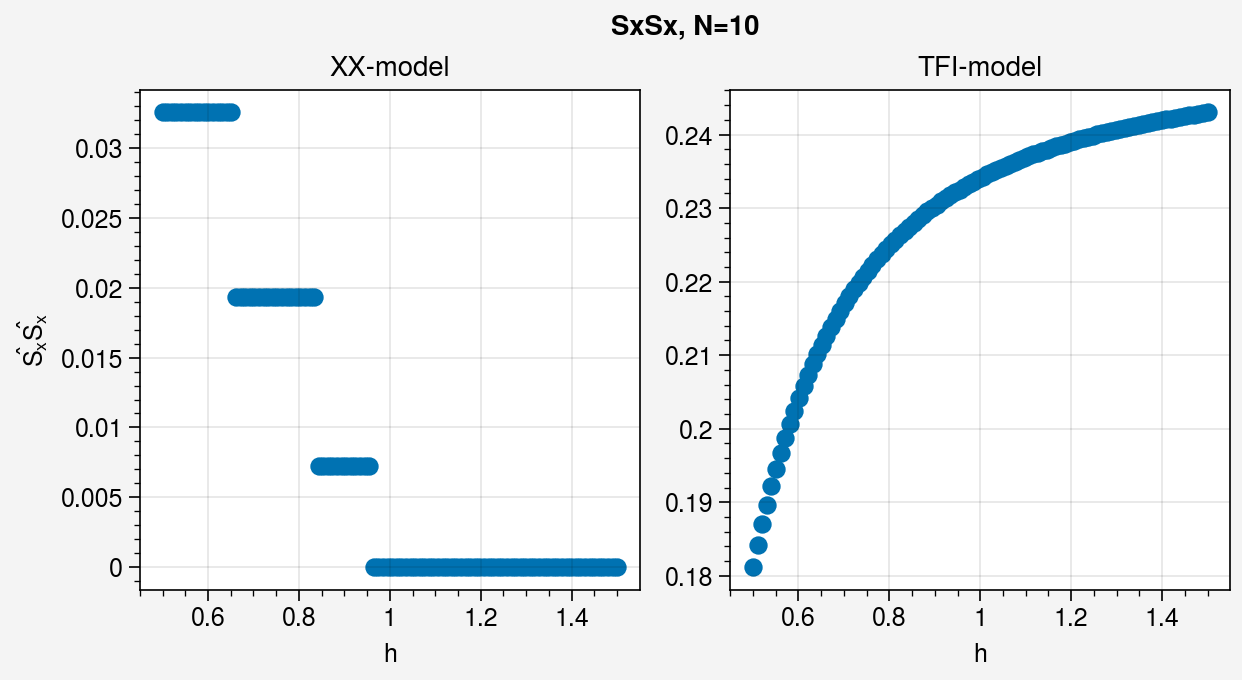

In [7]:
fig = pplt.figure(suptitle="SxSx, N=10", share=False)
ax = fig.subplot(121, xlabel="$h$", ylabel="$\hat{S_x}\hat{S_x}$", title="XX-model")
ax1 = fig.subplot(122, xlabel="$h$", title="TFI-model")
ax.scatter(hh, xx_results)
ax1.scatter(hh, ising_results)
fig.save("../../publication/figures/XX_vs_TFI.png")

In [8]:
N = 11
h = 0.84

hi = nk.hilbert.Spin(N=N, s=0.5)
xx = get_xx_netket_op(N, 1.0, h, hi)

state = nk.exact.lanczos_ed(xx, compute_eigenvectors=True)[1]
ops = get_spin_operators(N, hi)

In [9]:
def nth_bit(n, length):
    s = f"{n:b}"
    return "".join(["0"] * (length - len(s))) + s

In [10]:
def most_probable_n(state, n):
    probs = state * np.conj(state)
    idx = np.argsort(probs, axis=0)[::-1][:, 0]
    return idx[:20]

In [11]:
def magnetization(pp):
    conf = nth_bit(pp, N)
    m = 0.0
    for s in conf:
        if s == "0":
            m += 0.5
        else:
            m += -0.5
            
    return m

In [12]:
mms_xx = [magnetization(pp) for pp in most_probable_n(state, 20)]

In [13]:
ising = get_ising_netket_op(N, 1.0, h, hi)

state = nk.exact.lanczos_ed(ising, compute_eigenvectors=True)[1]
ops = get_spin_operators(N, hi)
mms_ising = [magnetization(pp) for pp in most_probable_n(state, 20)]

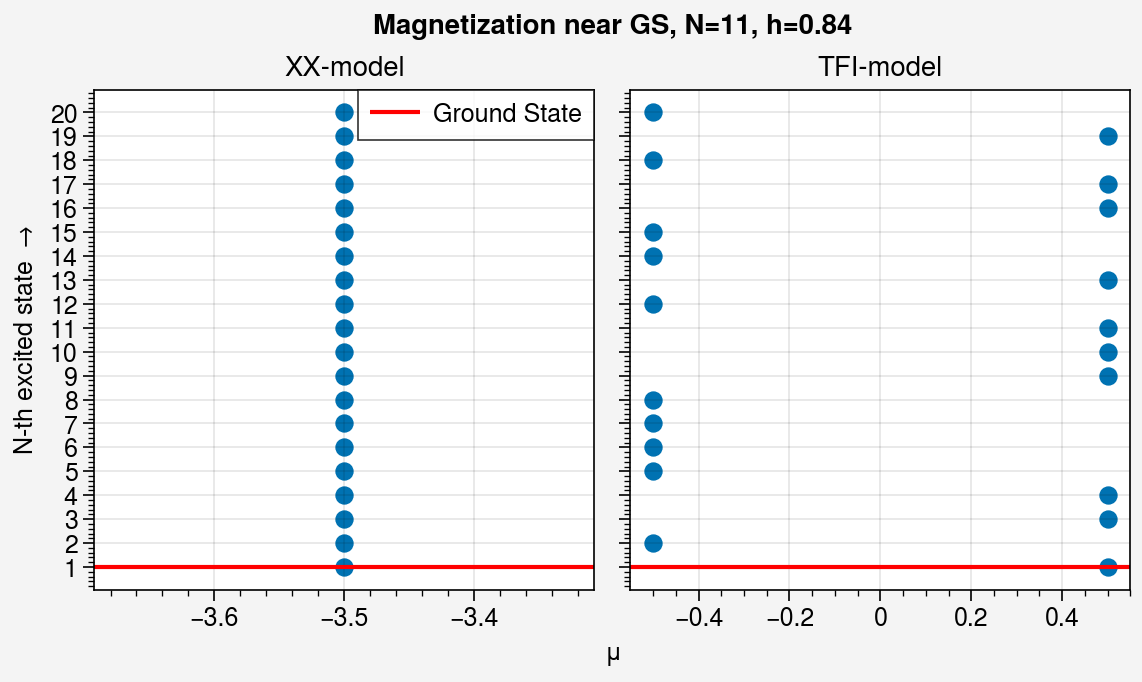

In [14]:
fig = pplt.figure(suptitle=f"Magnetization near GS, N={N}, h={h}", share=True)
ax = fig.subplot(121, ylabel="N-th excited state $\\rightarrow$", xlabel="$\mu$", title="XX-model")
ax.set_yticks(np.arange(1, 21))
ax.axhline(1.0, c="red", label="Ground State")
ax.legend()
ax1 = fig.subplot(122, xlabel="$h$", title="TFI-model")
ax1.axhline(1.0, c="red", label="GS")
ax.scatter(mms_xx, np.arange(1, 21))
ax1.scatter(mms_ising, np.arange(1, 21))
fig.save("../../publication/figures/XX_vs_TFI_GS.png")

In [15]:
N = 11
hh = np.linspace(0.0, 1.5, 200)
hi = nk.hilbert.Spin(N=N, s=0.5)

In [16]:
ees = []

for h in hh:
    xx = get_xx_netket_op(N, 1.0, h, hi)
    vv = nk.exact.lanczos_ed(xx, compute_eigenvectors=True, k=2)[1]
    
    e0 = (np.conj(vv[:, 0]).T @ xx.to_sparse() @ vv[:, 0]).real
    e1 = (np.conj(vv[:, 1]).T @ xx.to_sparse() @ vv[:, 1]).real
    
    ees.append([h, e0, e1])

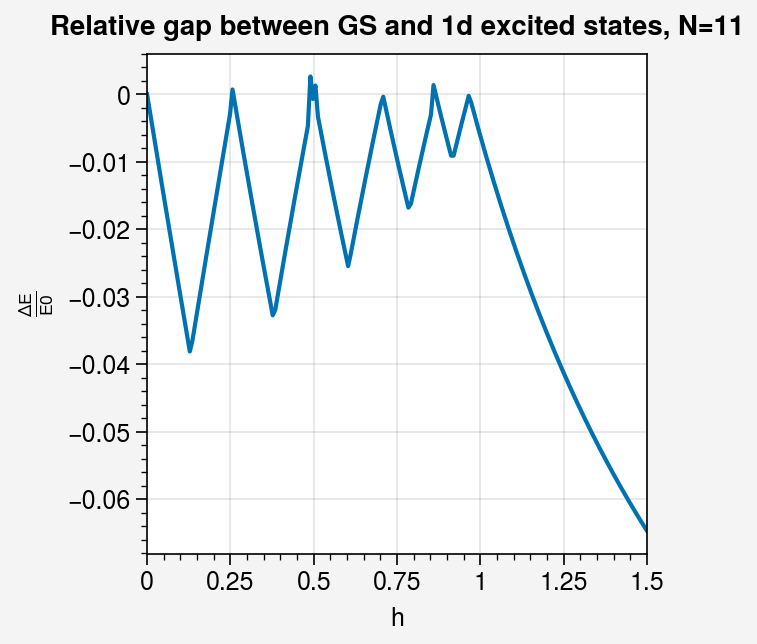

In [17]:
fig = pplt.figure(suptitle=f"Relative gap between GS and 1d excited states, N={N}")
ax = fig.subplot(ylabel="$\\frac{\Delta E}{E0}$", xlabel="$h$")
ax.plot([e[0] for e in ees], [(e[2] - e[1]) / e[1] for e in ees])
fig.save("../../publication/figures/XX_energy_gap.png")

In [18]:
import pandas as pd

In [19]:
d10 = pd.read_csv("../data/report_10.csv")
d21 = pd.read_csv("../data/report_21.csv")
d32 = pd.read_csv("../data/report_32.csv")
d64 = pd.read_csv("../data/report_64.csv")

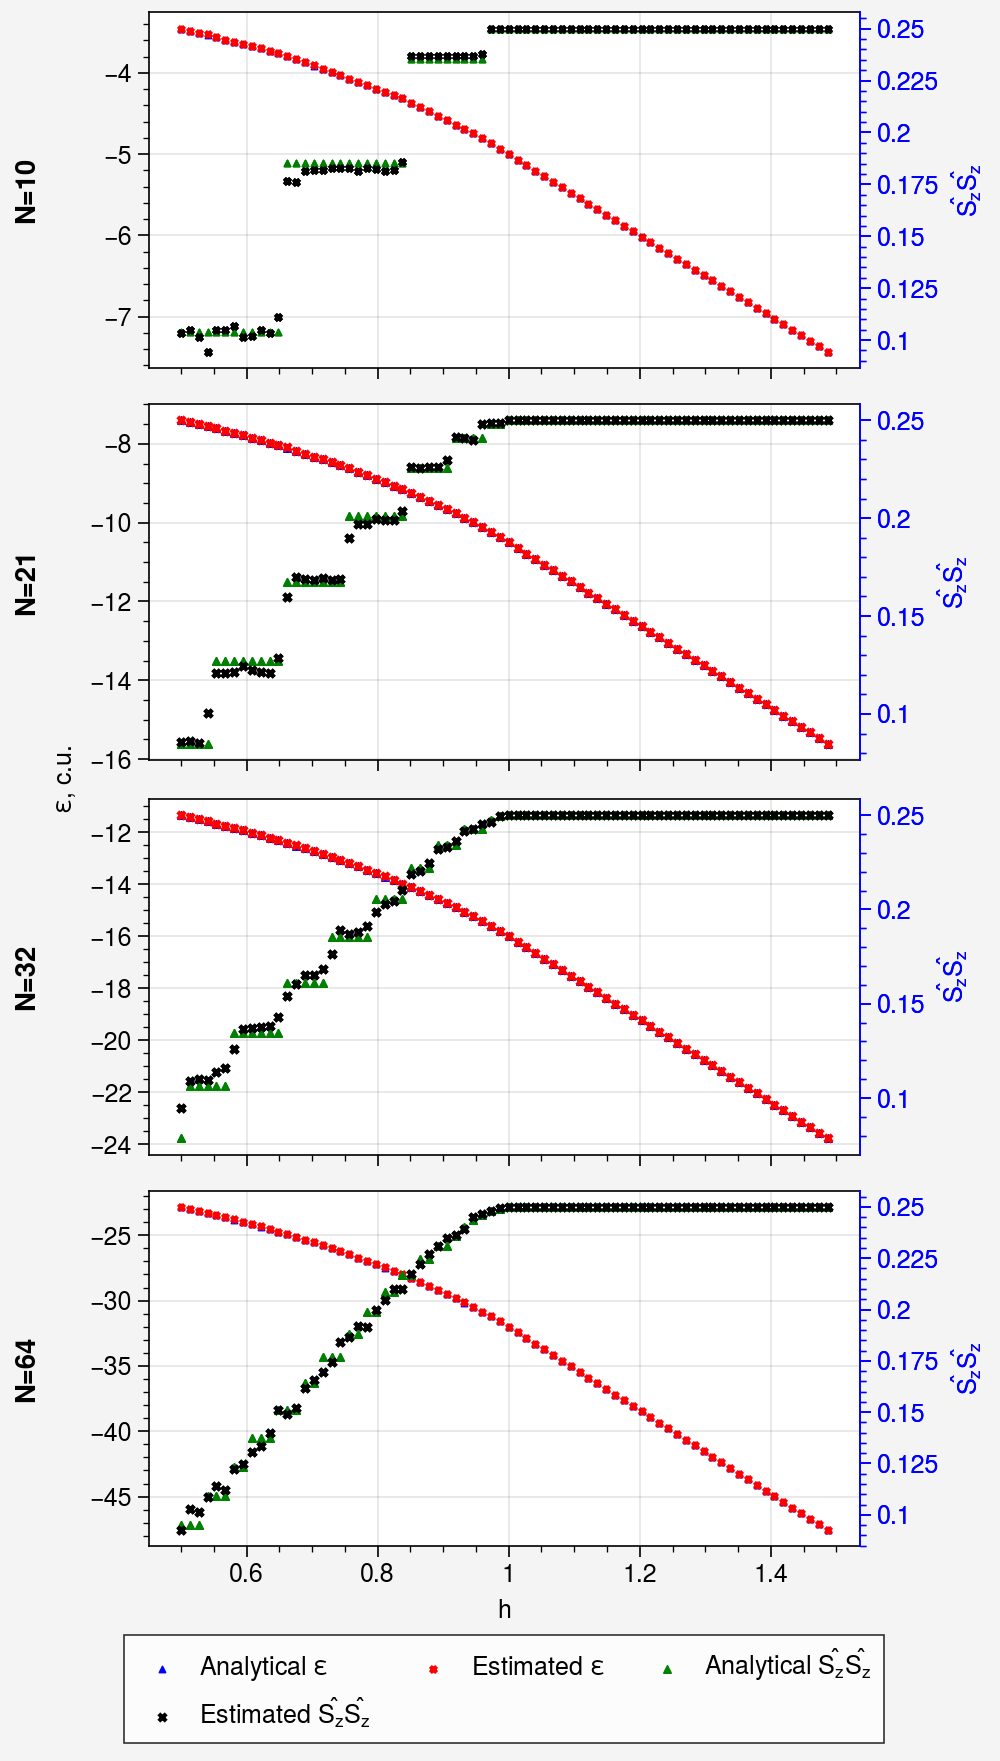

In [20]:
fig, axs = pplt.subplots(nrows=4, refaspect=2, figwidth=5, sharex=True)
axs[0].scatter(
    d10["h"],
    d10[["analytical_e", "estimated_e"]],
    cycle_kw={"m": ["^", "x"], "ms": [5, 5], "color": ["blue", "red"]},
    label=["Analytical $\epsilon$", "Estimated $\epsilon$"],
)
subax0 = axs[0].alty(label="$\hat{S_z}\hat{S_z}$", color="blue")
subax0.scatter(
    d10["h"],
    d10[["analytical_zz", "estimated_zz"]],
    cycle_kw={"m": ["^", "x"], "ms": [5, 5], "color": ["green", "black"]},
    label=["Analytical $\hat{S_z}\hat{S_z}$", "Estimated $\hat{S_z}\hat{S_z}$"],
)

axs[1].scatter(
    d21["h"],
    d21[["analytical_e", "estimated_e"]],
    cycle_kw={"m": ["^", "x"], "ms": [7, 7], "color": ["blue", "red"]},
    label=["Analytical $\epsilon$", "Estimated $\epsilon$"],
)
subax1 = axs[1].alty(label="$\hat{S_z}\hat{S_z}$", color="blue")
subax1.scatter(
    d21["h"],
    d21[["analytical_zz", "estimated_zz"]],
    cycle_kw={"m": ["^", "x"], "ms": [7, 7], "color": ["green", "black"]},
    label=["Analytical $\hat{S_z}\hat{S_z}$", "Estimated $\hat{S_z}\hat{S_z}$"],
)

axs[2].scatter(
    d32["h"],
    d32[["analytical_e", "estimated_e"]],
    cycle_kw={"m": ["^", "x"], "ms": [7, 7], "color": ["blue", "red"]},
    label=["Analytical $\epsilon$", "Estimated $\epsilon$"],
)
subax2 = axs[2].alty(label="$\hat{S_z}\hat{S_z}$", color="blue")
subax2.scatter(
    d32["h"],
    d32[["analytical_zz", "estimated_zz"]],
    cycle_kw={"m": ["^", "x"], "ms": [7, 7], "color": ["green", "black"]},
    label=["Analytical $\hat{S_z}\hat{S_z}$", "Estimated $\hat{S_z}\hat{S_z}$"],
)

axs[3].scatter(
    d64["h"],
    d64[["analytical_e", "estimated_e"]],
    cycle_kw={"m": ["^", "x"], "ms": [5, 5], "color": ["blue", "red"]},
    label=["Analytical $\epsilon$", "Estimated $\epsilon$"],
)
subax3 = axs[3].alty(label="$\hat{S_z}\hat{S_z}$", color="blue")
subax3.scatter(
    d64["h"],
    d64[["analytical_zz", "estimated_zz"]],
    cycle_kw={"m": ["^", "x"], "ms": [7, 7], "color": ["green", "black"]},
    label=["Analytical $\hat{S_z}\hat{S_z}$", "Estimated $\hat{S_z}\hat{S_z}$"],
)
axs[3].legend(loc="b")
fig.format(leftlabels=["N=10", "N=21", "N=32", "N=64"], ylabel="$\epsilon$, c.u.", xlabel="h")
fig.save("../../publication/figures/XX_zz_e_main.png")

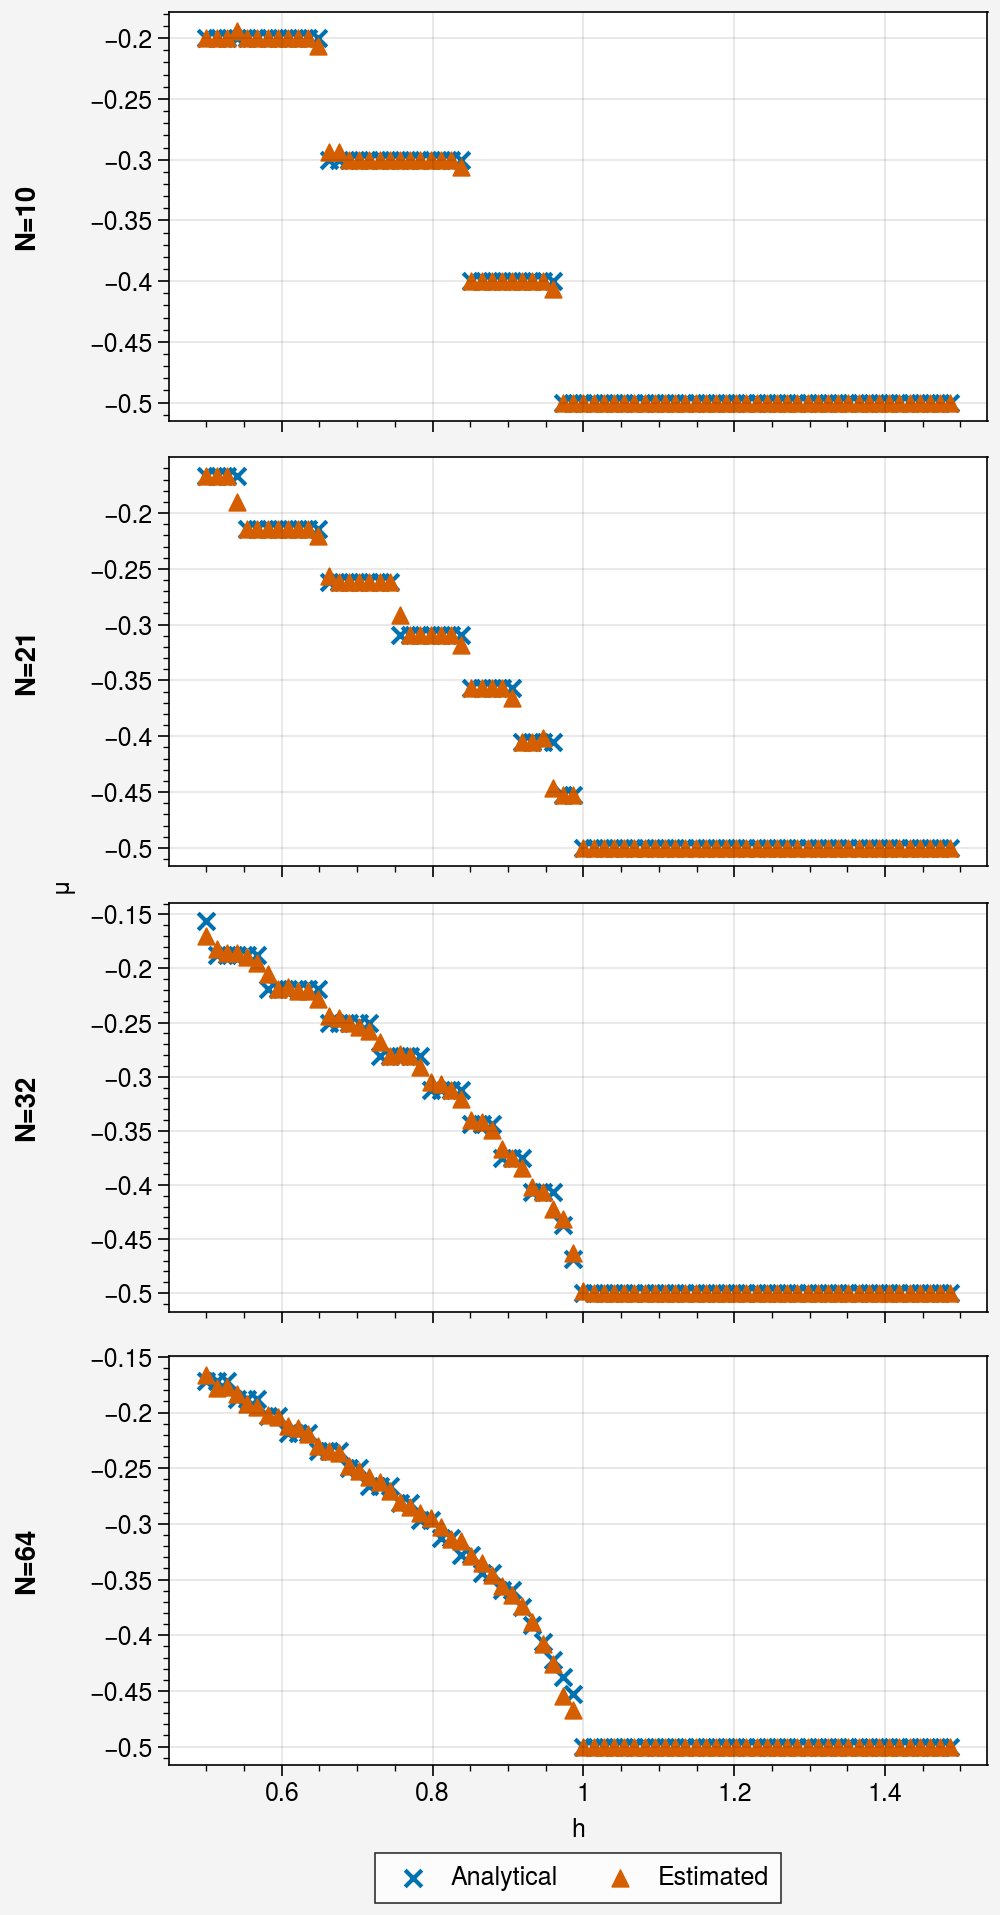

In [21]:
fig, axs = pplt.subplots(nrows=4, refaspect=2, figwidth=5, sharex=True)
axs[0].scatter(d10["h"], d10["analytical_m"], m="x")
axs[0].scatter(d10["h"], d10["estimated_m"], m="^")

axs[1].scatter(d21["h"], d21["analytical_m"], m="x")
axs[1].scatter(d21["h"], d21["estimated_m"], m="^")

axs[2].scatter(d32["h"], d32["analytical_m"], m="x")
axs[2].scatter(d32["h"], d32["estimated_m"], m="^")

axs[3].scatter(d64["h"], d64["analytical_m"], m="x", label="Analytical")
axs[3].scatter(d64["h"], d64["estimated_m"], m="^", label="Estimated")
axs[3].legend(loc="b")
fig.format(leftlabels=["N=10", "N=21", "N=32", "N=64"], ylabel="$\mu$", xlabel="h")
fig.save("../../publication/figures/XX_magn_main.png")

In [22]:
xy_data = pd.read_csv("../data/report_16_xy_lam_0.25.csv")

In [23]:
estimated_e = []
estimated_zz = []
N = 16
hi = nk.hilbert.Spin(N=N, s=0.5)

ops = get_spin_operators(N, hi)

for h in xy_data["h"].to_list():
    xy = get_xy_netket_op(N, 0.25, h, hi)
    vv = nk.exact.lanczos_ed(xy, compute_eigenvectors=True)
    estimated_zz.append((np.conj(vv[1]).T @ ops["zz"].to_sparse() @ vv[1]).real[0][0])
    estimated_e.append(vv[0])

In [24]:
xy_data["analytical_e"] = [e[0] for e in estimated_e]
xy_data["analytical_zz"] = estimated_zz

In [25]:
xy_data2 = xy_data.loc[xy_data["h"] <= 1.1]

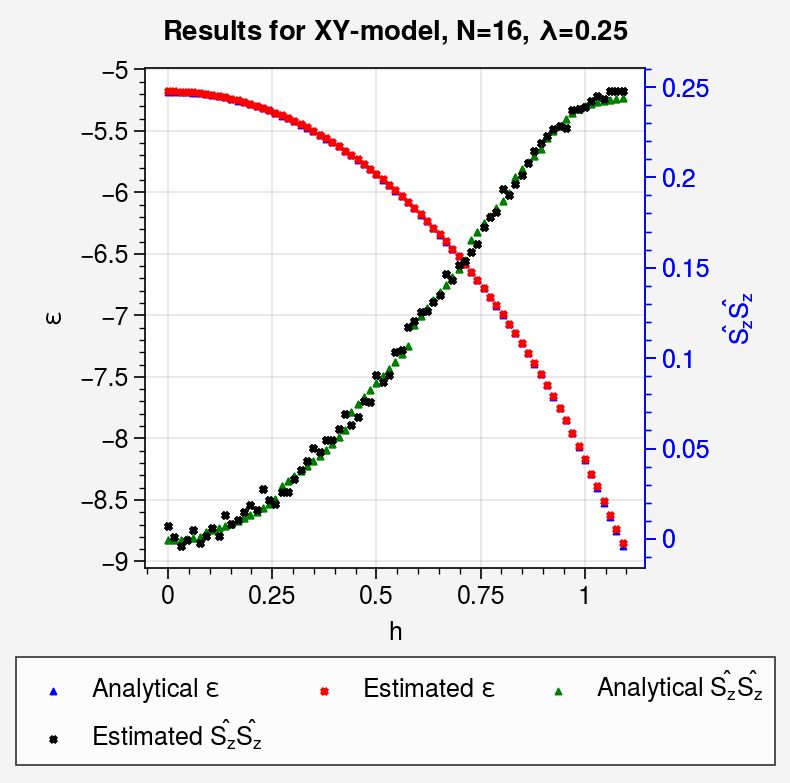

In [64]:
fig = pplt.figure(suptitle=f"Results for XY-model, N={16}, $\lambda$={0.25}")
ax = fig.subplot(ylabel="$\epsilon$", xlabel="$h$")
ax.scatter(
    xy_data2["h"],
    xy_data2[["analytical_e", "estimated_e"]],
    cycle_kw={"m": ["^", "x"], "ms": [5, 5], "color": ["blue", "red"]},
    label=["Analytical $\epsilon$", "Estimated $\epsilon$"],
)
subax = ax.alty(label="$\hat{S_z}\hat{S_z}$", color="blue")
subax.scatter(
    xy_data2["h"],
    xy_data2[["analytical_zz", "estimated_zz"]],
    cycle_kw={"m": ["^", "x"], "ms": [5, 5], "color": ["green", "black"]},
    label=["Analytical $\hat{S_z}\hat{S_z}$", "Estimated $\hat{S_z}\hat{S_z}$"],
)
ax.legend(loc="b")
fig.save("../../publication/figures/XY_zz_energy.png")

In [28]:
from src.model.machine import FF

In [51]:
N = 10

hi = nk.hilbert.Spin(N=N, s=0.5)
xx = get_xx_netket_op(N, 1.0, h, hi)

machine = FF(N, 2)
sr = nk.optimizer.SR(solver_restart=False)
sampler = nk.sampler.MetropolisHamiltonian(hi, hamiltonian=xx)
vmc = nk.driver.VMC(
    hamiltonian=xx,
    optimizer=nk.optimizer.Sgd(learning_rate=0.001),
    variational_state=nk.vqs.MCState(
        sampler=sampler,
        model=machine,
        n_samples=800,
    ),
    preconditioner=sr,
)

In [75]:
gs = nk.exact.lanczos_ed(xx)

In [72]:
logger = nk.logging.RuntimeLog()
vmc.run(n_iter=2000, out=logger)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [09:01<00:00,  3.69it/s, Energy=-3.234-0.002j ± 0.059 [σ²=2.800, R̂=1.4061]]


(<netket.logging.runtime_log.RuntimeLog at 0x7f980929d190>,)

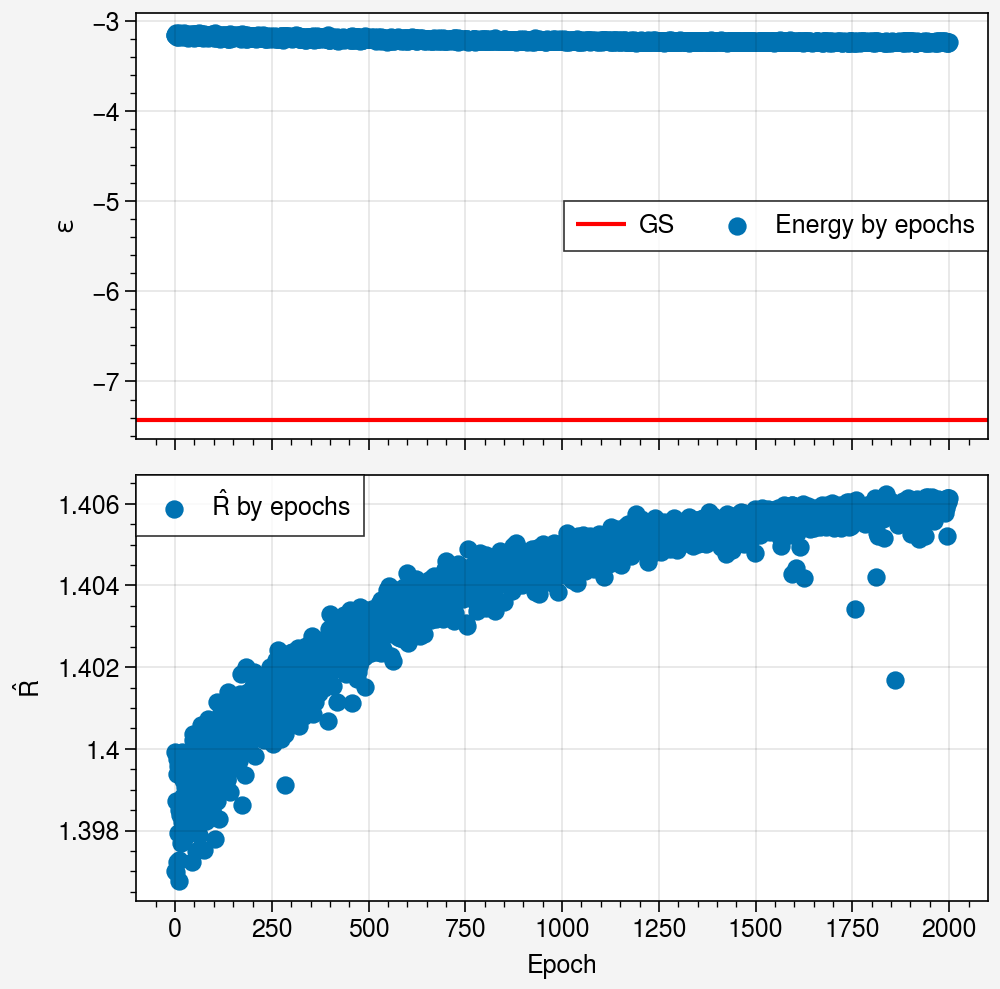

In [78]:
fig, axs = pplt.subplots(nrows=2, refaspect=2, figwidth=5, sharex=True, sharey=False)
axs[0].scatter(range(2000), logger.data["Energy"].to_dict()["Mean"].real, label="Energy by epochs")
axs[0].set_ylabel("$\epsilon$")
axs[0].axhline(gs[0], c="red", label="GS")
axs[1].scatter(range(2000), logger.data["Energy"].to_dict()["R_hat"], label="$\hat{R}$ by epochs")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("$\hat{R}$")
axs[0].legend()
axs[1].legend()
fig.save("../../publication/figures/bad_vmc_example.png")